In [1]:
import unittest
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Establecer semillas para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Verificar si hay GPU disponible y establecer el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Cargar el dataset
file_path = 'C:/Users/Ana Sofía Cantillo/Documents/Simulacion-Iris/housepricedata.csv'
data = pd.read_csv(file_path)

In [5]:
# Verificar que no hay valores nulos
if data.isnull().values.any():
    raise ValueError("El dataset contiene valores nulos. Por favor, límpialos antes de continuar.")

In [6]:
# Mostrar las primeras filas del dataset para verificar la carga correcta
print("Primeras filas del dataset:\n", data.head())

Primeras filas del dataset:
    LotArea  OverallQual  OverallCond  TotalBsmtSF  FullBath  HalfBath  \
0     8450            7            5          856         2         1   
1     9600            6            8         1262         2         0   
2    11250            7            5          920         2         1   
3     9550            7            5          756         1         0   
4    14260            8            5         1145         2         1   

   BedroomAbvGr  TotRmsAbvGrd  Fireplaces  GarageArea  AboveMedianPrice  
0             3             8           0         548                 1  
1             3             6           1         460                 1  
2             3             6           1         608                 1  
3             3             7           1         642                 0  
4             4             9           1         836                 1  


In [7]:
# Separar las características y las etiquetas
features = data.drop('AboveMedianPrice', axis=1)
labels = data['AboveMedianPrice']

In [8]:
# Normalizar las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [9]:
# Convertir a tensores de PyTorch y mover a dispositivo
features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)

In [10]:
# Definir la arquitectura de la red neuronal con Dropout y parámetros ajustables
class HousePriceNN(nn.Module):
    def __init__(self, input_size=features_tensor.shape[1], hidden1_size=64, hidden2_size=32, dropout_prob=0.5):
        super(HousePriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [11]:
# Inicializar el modelo, el criterio y el optimizador
modelo = HousePriceNN().to(device)
criterio = nn.MSELoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.001)

In [12]:
# Función para guardar el modelo
def guardar_modelo(modelo, optimizador, path='house_price_model.pth'):
    torch.save({
        'model_state_dict': modelo.state_dict(),
        'optimizer_state_dict': optimizador.state_dict(),
    }, path)


In [13]:
# Función para cargar el modelo
def cargar_modelo(modelo, optimizador, path='house_price_model.pth'):
    checkpoint = torch.load(path)
    modelo.load_state_dict(checkpoint['model_state_dict'])
    optimizador.load_state_dict(checkpoint['optimizer_state_dict'])


In [14]:
# Definir el proceso de entrenamiento con validación y Early Stopping
def entrenar_modelo(modelo, criterio, optimizador, X_train, y_train, X_val, y_val, num_epochs=100, paciencia=10):
    perdidas_entrenamiento = []
    perdidas_validacion = []
    
    mejor_perdida_val = float('inf')
    epochs_sin_mejorar = 0
    
    for epoch in range(num_epochs):
        modelo.train()
        
        salidas = modelo(X_train)
        perdida = criterio(salidas, y_train)
        
        optimizador.zero_grad()
        perdida.backward()
        optimizador.step()
        
        perdidas_entrenamiento.append(perdida.item())
        
        modelo.eval()
        with torch.no_grad():
            salidas_val = modelo(X_val)
            perdida_val = criterio(salidas_val, y_val)
            perdidas_validacion.append(perdida_val.item())
        
        if perdida_val < mejor_perdida_val:
            mejor_perdida_val = perdida_val
            epochs_sin_mejorar = 0
            guardar_modelo(modelo, optimizador)
        else:
            epochs_sin_mejorar += 1
        
        if epochs_sin_mejorar == paciencia:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {perdida.item():.4f}, Val Loss: {perdida_val.item():.4f}')
    
    return perdidas_entrenamiento, perdidas_validacion

In [15]:
# Validación cruzada con KFold y diferentes arquitecturas
def validar_cruzado_modelo(clase_modelo, criterio, clase_optimizador, características, etiquetas, n_splits=5, num_epochs=100, paciencia=10):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    resultados_folds = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(características)):
        print(f'Fold {fold+1}/{n_splits}')
        
        X_train, X_val = características[train_idx], características[val_idx]
        y_train, y_val = etiquetas[train_idx], etiquetas[val_idx]
        
        modelo = clase_modelo().to(device)
        optimizador = clase_optimizador(modelo.parameters(), lr=0.001)
        
        perdidas_entrenamiento, perdidas_validacion = entrenar_modelo(
            modelo, criterio, optimizador, X_train, y_train, X_val, y_val, num_epochs, paciencia
        )
        
        resultados_folds.append({
            'perdidas_entrenamiento': perdidas_entrenamiento,
            'perdidas_validacion': perdidas_validacion,
        })
    
    return resultados_folds

In [16]:
# Experimentar con diferentes arquitecturas y parámetros
arquitecturas = [
    {'hidden1_size': 64, 'hidden2_size': 32, 'dropout_prob': 0.5},
    {'hidden1_size': 128, 'hidden2_size': 64, 'dropout_prob': 0.5},
    {'hidden1_size': 128, 'hidden2_size': 32, 'dropout_prob': 0.3},
]

resultados = []
for arch in arquitecturas:
    print(f'Testando arquitectura: {arch}')
    clase_modelo = lambda: HousePriceNN(input_size=features_tensor.shape[1], **arch)
    resultado = validar_cruzado_modelo(clase_modelo, criterio, optim.Adam, features_tensor, labels_tensor, num_epochs=100, paciencia=10)
    resultados.append(resultado)


Testando arquitectura: {'hidden1_size': 64, 'hidden2_size': 32, 'dropout_prob': 0.5}
Fold 1/5
Epoch [10/100], Train Loss: 0.2863, Val Loss: 0.1838
Epoch [20/100], Train Loss: 0.2189, Val Loss: 0.1369
Epoch [30/100], Train Loss: 0.2055, Val Loss: 0.1234
Epoch [40/100], Train Loss: 0.2031, Val Loss: 0.1155
Epoch [50/100], Train Loss: 0.1876, Val Loss: 0.1062
Epoch [60/100], Train Loss: 0.1630, Val Loss: 0.1003
Epoch [70/100], Train Loss: 0.1677, Val Loss: 0.0967
Epoch [80/100], Train Loss: 0.1550, Val Loss: 0.0933
Epoch [90/100], Train Loss: 0.1506, Val Loss: 0.0878
Epoch [100/100], Train Loss: 0.1386, Val Loss: 0.0853
Fold 2/5
Epoch [10/100], Train Loss: 0.3622, Val Loss: 0.3142
Epoch [20/100], Train Loss: 0.2692, Val Loss: 0.1846
Epoch [30/100], Train Loss: 0.2349, Val Loss: 0.1460
Epoch [40/100], Train Loss: 0.2132, Val Loss: 0.1346
Epoch [50/100], Train Loss: 0.1830, Val Loss: 0.1189
Epoch [60/100], Train Loss: 0.1807, Val Loss: 0.1101
Epoch [70/100], Train Loss: 0.1743, Val Loss: 0.

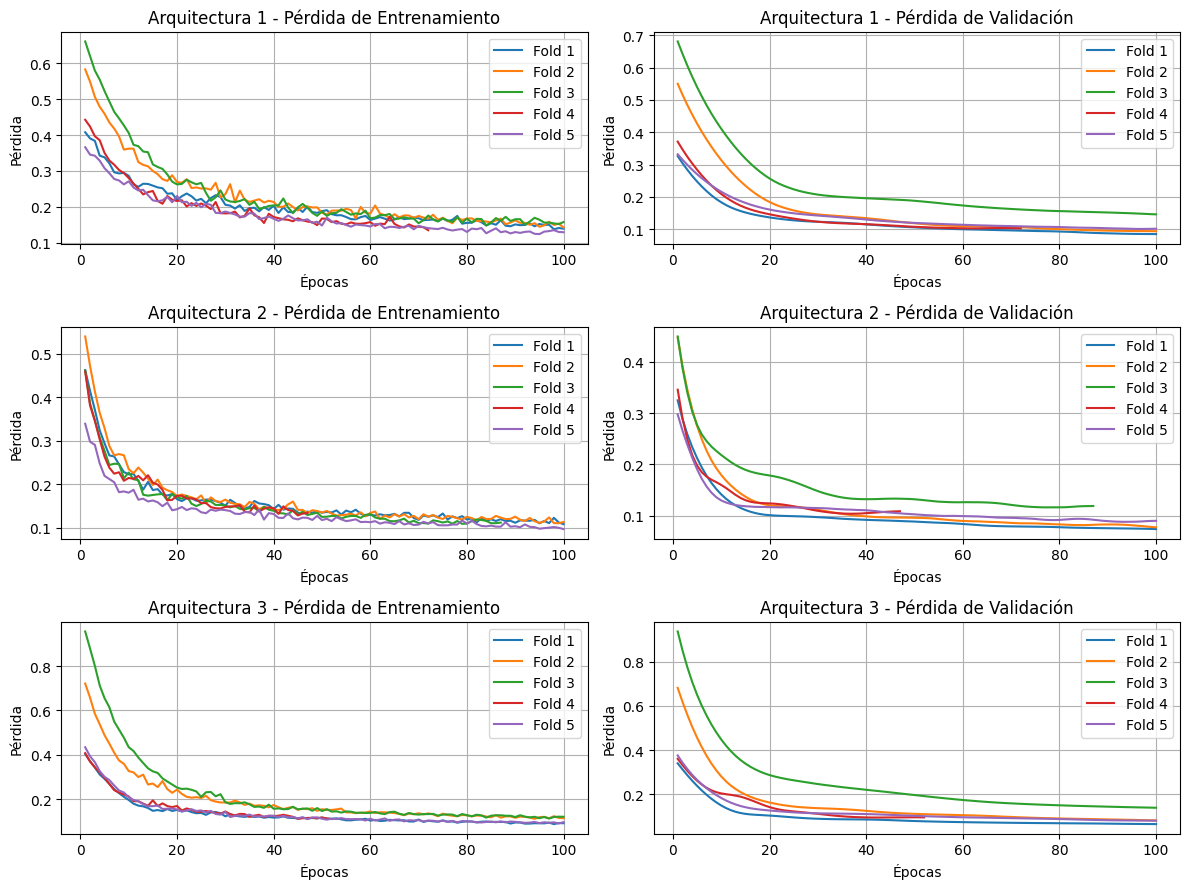

In [17]:
# Graficar las pérdidas y las métricas adicionales para la validación cruzada
fig, axes = plt.subplots(len(resultados), 2, figsize=(12, 9))

for arch_idx, resultado in enumerate(resultados):
    for fold_idx, fold_result in enumerate(resultado):
        rango_epocas = range(1, len(fold_result['perdidas_entrenamiento']) + 1)

        axes[arch_idx, 0].plot(rango_epocas, fold_result['perdidas_entrenamiento'], label=f'Fold {fold_idx+1}')
        axes[arch_idx, 1].plot(rango_epocas, fold_result['perdidas_validacion'], label=f'Fold {fold_idx+1}')

for arch_idx, ax in enumerate(axes):
    ax[0].set_title(f'Arquitectura {arch_idx+1} - Pérdida de Entrenamiento')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].set_title(f'Arquitectura {arch_idx+1} - Pérdida de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Pérdida')
    ax[1].legend()
    ax[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Implementación de pruebas unitarias
class TestHousePriceNN(unittest.TestCase):
    def setUp(self):
        self.modelo = HousePriceNN().to(device)
        self.criterio = nn.MSELoss()
        self.optimizador = optim.Adam(self.modelo.parameters(), lr=0.001)
        
        # Generar datos de prueba
        self.X_train_tensor = features_tensor[:100]
        self.y_train_tensor = labels_tensor[:100]
        self.X_val_tensor = features_tensor[100:150]
        self.y_val_tensor = labels_tensor[100:150]

    def test_inicializacion(self):
        # Verificar si la red neuronal se inicializa correctamente
        self.assertEqual(self.modelo.fc1.in_features, features_tensor.shape[1])
        self.assertEqual(self.modelo.fc1.out_features, 64)
        self.assertEqual(self.modelo.fc2.in_features, 64)
        self.assertEqual(self.modelo.fc2.out_features, 32)
        self.assertEqual(self.modelo.fc3.in_features, 32)
        self.assertEqual(self.modelo.fc3.out_features, 1)

    def test_paso_adelante(self):
        # Verificar si la salida tiene la forma correcta
        salida = self.modelo(self.X_train_tensor)
        self.assertEqual(salida.shape, (self.X_train_tensor.shape[0], 1))

    def test_paso_entrenamiento(self):
        # Realizar varias pasadas de entrenamiento y verificar si la pérdida se reduce
        perdida_inicial = self.criterio(self.modelo(self.X_train_tensor), self.y_train_tensor).item()
        for _ in range(10):
            self.optimizador.zero_grad()
            perdida = self.criterio(self.modelo(self.X_train_tensor), self.y_train_tensor)
            perdida.backward()
            self.optimizador.step()
        nueva_perdida = self.criterio(self.modelo(self.X_train_tensor), self.y_train_tensor).item()
        self.assertLess(nueva_perdida, perdida_inicial)

    def test_paso_validacion(self):
        # Verificar la precisión en el conjunto de validación
        self.modelo.eval()
        with torch.no_grad():
            salida_val = self.modelo(self.X_val_tensor)
            perdida_val = self.criterio(salida_val, self.y_val_tensor).item()
            mae = torch.mean(torch.abs(salida_val - self.y_val_tensor)).item()
            mse = torch.mean((salida_val - self.y_val_tensor) ** 2).item()
        
        # Asegurarse de que las métricas son valores razonables
        self.assertGreaterEqual(mae, 0.0)
        self.assertGreaterEqual(mse, 0.0)

    def test_guardar_y_cargar_modelo(self):
        # Guardar y cargar el modelo, y verificar que los estados del modelo son idénticos
        ruta_guardar_modelo = 'test_house_price_model.pth'
        guardar_modelo(self.modelo, self.optimizador, ruta_guardar_modelo)
        
        nuevo_modelo = HousePriceNN().to(device)
        nuevo_optimizador = optim.Adam(nuevo_modelo.parameters(), lr=0.001)
        cargar_modelo(nuevo_modelo, nuevo_optimizador, ruta_guardar_modelo)
        
        for param_original, param_cargado in zip(self.modelo.parameters(), nuevo_modelo.parameters()):
            self.assertTrue(torch.equal(param_original, param_cargado))


In [19]:
# Ejecutar las pruebas unitarias
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.082s

OK


In [20]:
# Entrenar el modelo final en todos los datos y predecir el precio más bajo
mejor_arquitectura = arquitecturas[0]  # Suponiendo que seleccionamos la primera arquitectura como la mejor
mejor_modelo = HousePriceNN(input_size=features_tensor.shape[1], **mejor_arquitectura).to(device)
mejor_optimizador = optim.Adam(mejor_modelo.parameters(), lr=0.00002)

In [21]:
# Entrenar el modelo final en todos los datos
perdidas_entrenamiento, perdidas_validacion = entrenar_modelo(
    mejor_modelo, criterio, mejor_optimizador, features_tensor, labels_tensor, features_tensor, labels_tensor, num_epochs=100, paciencia=10
)

Epoch [10/100], Train Loss: 0.7457, Val Loss: 0.7245
Epoch [20/100], Train Loss: 0.7221, Val Loss: 0.7180
Epoch [30/100], Train Loss: 0.7159, Val Loss: 0.7116
Epoch [40/100], Train Loss: 0.7105, Val Loss: 0.7053
Epoch [50/100], Train Loss: 0.7071, Val Loss: 0.6990
Epoch [60/100], Train Loss: 0.6953, Val Loss: 0.6927
Epoch [70/100], Train Loss: 0.6933, Val Loss: 0.6865
Epoch [80/100], Train Loss: 0.6733, Val Loss: 0.6803
Epoch [90/100], Train Loss: 0.6694, Val Loss: 0.6741
Epoch [100/100], Train Loss: 0.6640, Val Loss: 0.6679


In [22]:
# Hacer predicciones con el modelo final entrenado
mejor_modelo.eval()
with torch.no_grad():
    predicciones = mejor_modelo(features_tensor).cpu().numpy()


In [23]:
# Encontrar el valor más bajo
precio_minimo = np.min(predicciones)
print(f'El valor de la casa más barata predicho es: {precio_minimo}')

El valor de la casa más barata predicho es: -0.3762695789337158
